In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer as qv
import boulderopal as bo

#bo.cloud.set_verbosity('QUIET')
plt.style.use(qv.get_qctrl_style())

controls_for_plots = lambda opt: {
    '$\\Delta$': opt['output']['delta'],
    '$\\Omega$': opt['output']['omega'],
    '$\\Phi$': opt['output']['phi']
}

In [2]:
# Set parameters.
omega_max = 5 * 2 * np.pi * 1e6 # rad/s
delta_max = omega_max
tau = 0.4 * 1e-6 # s

# Define the control.
segment_count = 2
sample_times = np.linspace(0, tau, 200)

# Define basis.
basis_labels = ['0', '1', 'r', '11', 'W']

# Components for the drive operator.
drive_operator = np.zeros((5, 5))
drive_operator[1, 2] = 1
drive_operator[3, 4] = np.sqrt(2)

# Components for the detuning operator.
detuning_operator = np.diag([0, 0, -1, 0, -1])

# Components for the CZ operator.
cz_0 = np.diag([1, 0, 0, 0, 0])
cz_1 = np.diag([0, 1, 0, 0, 0])
cz_11 = np.diag([0, 0, 0, 1, 0])

In [78]:
def optimize_LP_gate(omega_max, delta_max, tau, segment_count,optimization_count=10,**robustness):
    graph = bo.Graph()
    sample_times = np.linspace(0, tau, 200)
    # Real piece-wise constant signal representing the detuning.
    delta = (
        graph.real_optimizable_pwc_signal(
            segment_count = 1, 
            duration = tau, 
            minimum = 0,
            maximum = delta_max,
            name = 'delta'
        )
    )

    # Real piece-wise constant signal representing the Rabi amplitude.
    omega = (
        graph.real_optimizable_pwc_signal(
            segment_count = 1, 
            duration = tau, 
            minimum = 0,
            maximum = omega_max,
            name = 'omega'
        )
    )

    # Real piece-wise constant signal representing the Rabi phase.
    phi = (
        graph.real_optimizable_pwc_signal(
            segment_count = segment_count, 
            duration = tau, 
            minimum = 0,
            maximum = 2 * np.pi, 
            name = 'phi'
        )
    )

    # Real scalar signal representing the single qubit phase.
    psi = (
        graph.optimizable_scalar(
            lower_bound = 0,
            upper_bound = 2 * np.pi, 
            name = 'psi'
        )
    )
    
    
        
    # Define the Hamiltonian.
    drive_term = graph.hermitian_part(omega * graph.exp(1j * phi) * drive_operator)
    delta_term = delta * detuning_operator
    hamiltonian = drive_term + delta_term

        # Define the target operator.
    target = (
        graph.target(
            operator = (
                cz_0 +
                graph.exp(1j * psi) * cz_1 + 
                graph.exp(1j * (2 * psi + np.pi)) * cz_11
            )
        )
    )
    
    
    #Define noise list to include robustness
    noise_list = []
    if robustness["dephasing"]:
        noise_list.append(detuning_operator / tau)
    if robustness["amplitude"]:
        noise_list.append(drive_term)
    penalty = robustness["decay"]
    
    
    # Unitary time evolution.
    unitary = (
        graph.time_evolution_operators_pwc(
            hamiltonian = hamiltonian, 
            sample_times = sample_times, 
            name = 'unitary'
        )
    )

    # Infidelity.
    infidelity = (
        graph.infidelity_pwc(
            hamiltonian = hamiltonian,
            target = target,
            noise_operators=noise_list,
            name = 'infidelity'
        )
    )

    # Cost function.
    cost_function = (
        graph.sum(
            infidelity
        )
    )
    cost_function.name = 'cost_function'
    
    result = (
    bo.run_optimization(
        graph = graph,
        cost_node_name = 'cost_function',
        optimization_count=optimization_count,
        output_node_names = [
            'omega', 
            'delta', 
            'phi', 
            'psi', 
            'unitary',
            'infidelity',
        ],
    )
)
    return result

In [89]:
result_non_robust = optimize_LP_gate(
    omega_max, 
    delta_max, 
    tau, 
    segment_count = 2,
    optimization_count=50,
    dephasing=False,
    amplitude=False,
    decay=0,
)

print("Gate infidelity is", f"{result_non_robust['output']['infidelity']['value']:.3e}")

Your task (action_id="1993471") is queued.
Your task (action_id="1993471") has started.
Your task (action_id="1993471") has completed.
Gate infidelity is 0.000e+00


In [90]:
eta = result_non_robust['output']['delta']['values'][0] / result_non_robust['output']['omega']['values'][0]
xi = np.abs(result_non_robust['output']['phi']['values'][0] - result_non_robust['output']['phi']['values'][1])
omegatau = result_non_robust['output']['omega']['values'][0] * tau / 2

print(f"Infidelity: {result_non_robust['output']['infidelity']['value']:.3e}")
print(f"Gate time: {omegatau}")
print(f"Ratio of detuning and Rabi frequncy: {eta}")
print(f"Phase jump: {xi}")
print(f"Equivalent phase jump: {2 * np.pi - xi}")
print(f"Single qubit phase: {result_non_robust['output']['psi']['value']}")

Infidelity: 0.000e+00
Gate time: 4.292681790147548
Ratio of detuning and Rabi frequncy: 0.37737089117872247
Phase jump: 2.3807629823847636
Equivalent phase jump: 3.9024223247948227
Single qubit phase: 2.3807628770408362


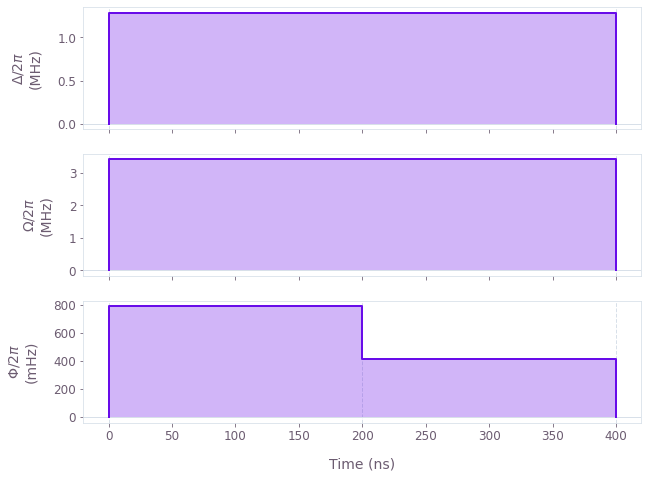

In [91]:
qv.plot_controls(controls_for_plots(result_non_robust))

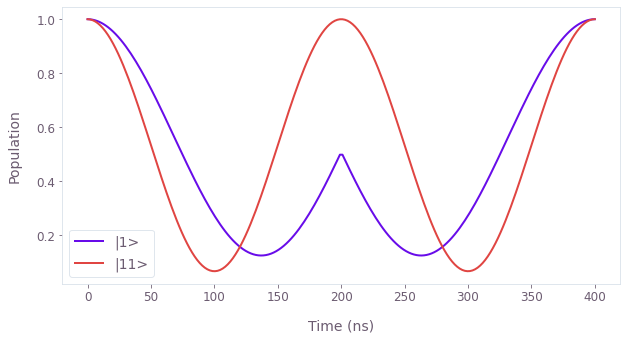

In [92]:
u = result_non_robust['output']['unitary']['value']

psi1 = np.array([0,1,0,0,0])
out1 = np.abs(np.transpose(psi1) @ u @ psi1)**2
psi11 = np.array([0,0,0,1,0])
out11 = np.abs(np.transpose(psi11) @ u @ psi11)**2

plt.plot(1e9 * sample_times, out1)
plt.plot(1e9 * sample_times, out11)
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.legend(['|1>', '|11>'])

#### Optimizing a robust LP gate


In [93]:
result_robust = optimize_LP_gate(
    omega_max, 
    delta_max, 
    tau,
    optimization_count=50,
    segment_count = 2,
    dephasing=True,
    amplitude=True,
    decay=0,
)

print("Gate infidelity is", f"{result_robust['output']['infidelity']['value']:.3e}")


Your task (action_id="1993472") is queued.
Your task (action_id="1993472") has started.
Your task (action_id="1993472") has completed.
Gate infidelity is 4.598e-01


In [94]:
eta = result_robust['output']['delta']['values'][0] / result_robust['output']['omega']['values'][0]
xi = np.abs(result_robust['output']['phi']['values'][0] - result_robust['output']['phi']['values'][1])
omegatau = result_robust['output']['omega']['values'][0] * tau / 2

print(f"Infidelity: {result_robust['output']['infidelity']['value']:.3e}")
print(f"Gate time: {omegatau}")
print(f"Ratio of detuning and Rabi frequncy: {eta}")
print(f"Phase jump: {xi}")
print(f"Equivalent phase jump: {2 * np.pi - xi}")
print(f"Single qubit phase: {result_robust['output']['psi']['value']}")

Infidelity: 4.598e-01
Gate time: 5.313911595277104
Ratio of detuning and Rabi frequncy: 0.035437422619138854
Phase jump: 3.145290169474948
Equivalent phase jump: 3.1378951377046382
Single qubit phase: 1.6524825476201066


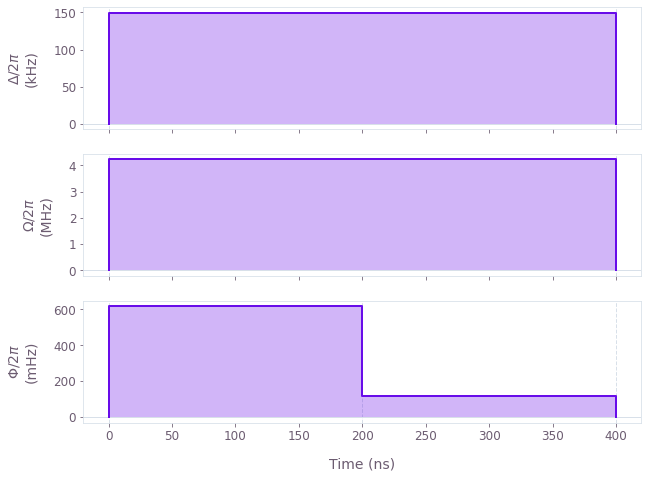

In [95]:
qv.plot_controls(controls_for_plots(result_robust))

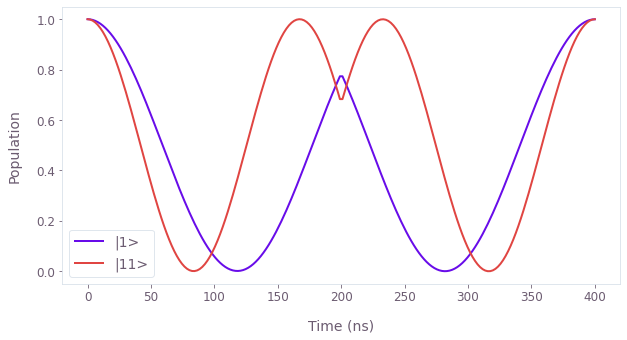

In [96]:
u = result_robust['output']['unitary']['value']

psi1 = np.array([0,1,0,0,0])
out1 = np.abs(np.transpose(psi1) @ u @ psi1)**2
psi11 = np.array([0,0,0,1,0])
out11 = np.abs(np.transpose(psi11) @ u @ psi11)**2

plt.plot(1e9 * sample_times, out1)
plt.plot(1e9 * sample_times, out11)
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.legend(['|1>', '|11>'])

#### Comparing robustness to noise

In [98]:
def run_coherent_simulation(
    control_results, detuning_error_value, amplitude_error_value
):
    graph = bo.Graph()
    Omega = graph.pwc_signal(
        values = control_results["output"]["omega"]["values"],
        duration = tau,
        name = 'Omega',
    )
    Delta = graph.pwc_signal(
        values = control_results["output"]["delta"]["values"],
        duration = tau,
        name = 'Delta',
    )
    detuning_error = graph.pwc_signal(
        values=[detuning_error_value],
        duration=tau,
    )
    amplitude_error = graph.pwc_signal(
        values = [amplitude_error_value],
        duration=tau,
    )

    phi = graph.pwc_signal(
        values = control_results["output"]["phi"]["values"],
        duration=tau,
    )
    # add noise to the hamiltonian
    hamiltonian = (
    graph.hermitian_part(Omega * (1.0 + amplitude_error) * graph.exp(1j * phi) * drive_operator) + 
    (Delta + detuning_error) * detuning_operator
    )
    
    psi = control_results["output"]["psi"]["value"]

    target = (
        graph.target(
            operator = (
                cz_0 +
                graph.exp(1j * psi) * cz_1 + 
                graph.exp(1j * (2 * psi + np.pi)) * cz_11
            )
        )
    )

    infidelity = (
        graph.infidelity_pwc(
            hamiltonian = hamiltonian,
            target = target,
            name = 'infidelity'
        )
    )

    result = bo.execute_graph(graph, "infidelity")

    return result

In [113]:
scan_point_count = 5
detuning_error_values = (
    np.linspace(-0.2, 0.2, num=scan_point_count) * 2 * np.pi * 1e6
)  # rad/s
amplitude_error_values = np.linspace(-0.3, 0.3, num=scan_point_count)

# Run the dephasing/amplitude error scans for non-robust LP gate.
infidelities_LP = np.zeros((scan_point_count,scan_point_count))
infidelities_LP_robust = np.zeros((scan_point_count,scan_point_count))
for i in range(scan_point_count):
    for j in range(scan_point_count):
        result = run_coherent_simulation(result_non_robust, detuning_error_values[i], amplitude_error_values[j])
        infidelities_LP[i][j] = result["output"]["infidelity"]["value"]
        
        infidelities_LP_robust[i][j] = run_coherent_simulation(result_non_robust, 
                                                               detuning_error_values[i], 
                                                               amplitude_error_values[j]
                                                              )["output"]["infidelity"]["value"]

[[2.02019321e-01 4.68627799e-02 1.48326599e-02 9.54070779e-02
  2.47476672e-01]
 [2.26223169e-01 5.21715387e-02 3.66714442e-03 7.78877985e-02
  2.34629351e-01]
 [2.55630706e-01 6.47083593e-02 1.55431223e-15 6.72764492e-02
  2.27809255e-01]
 [2.89334768e-01 8.38410699e-02 3.55098706e-03 6.35423962e-02
  2.27044774e-01]
 [3.26399638e-01 1.08836106e-01 1.39118327e-02 6.65302801e-02
  2.32254011e-01]]
Your task (action_id="1993550") has started.
Your task (action_id="1993550") has completed.
Your task (action_id="1993551") has started.
Your task (action_id="1993551") has completed.
Your task (action_id="1993552") has started.
Your task (action_id="1993552") has completed.
Your task (action_id="1993553") has started.
Your task (action_id="1993553") has completed.
Your task (action_id="1993554") has started.
Your task (action_id="1993554") has completed.
Your task (action_id="1993555") has started.
Your task (action_id="1993555") has completed.
Your task (action_id="1993556") has completed.


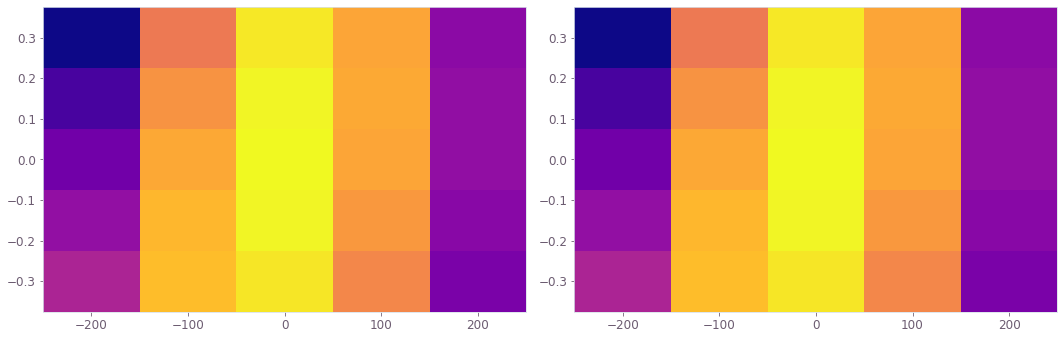

In [117]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.2)
scans = [infidelities_LP,infidelities_LP_robust]
min_inf = np.min([inf for inf in scans])
max_inf = np.max([inf for inf in scans])
for i in range(2):
    axs[i].pcolormesh(
        detuning_error_values /(2*np.pi*1e3),
        amplitude_error_values,
        scans[i],
        vmin = min_inf,
        vmax = max_inf,
        cmap = plt.colormaps["plasma"].reversed(),
    )
